In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [23]:
torch.manual_seed(42)

# hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


# Load and prepare the dataset

In [ ]:
# transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download MNIST dataset
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
train_dataset.__len__

<bound method MNIST.__len__ of Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )>

In [34]:
test_dataset.__len__

<bound method MNIST.__len__ of Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )>

Visualize some examples from the dataset

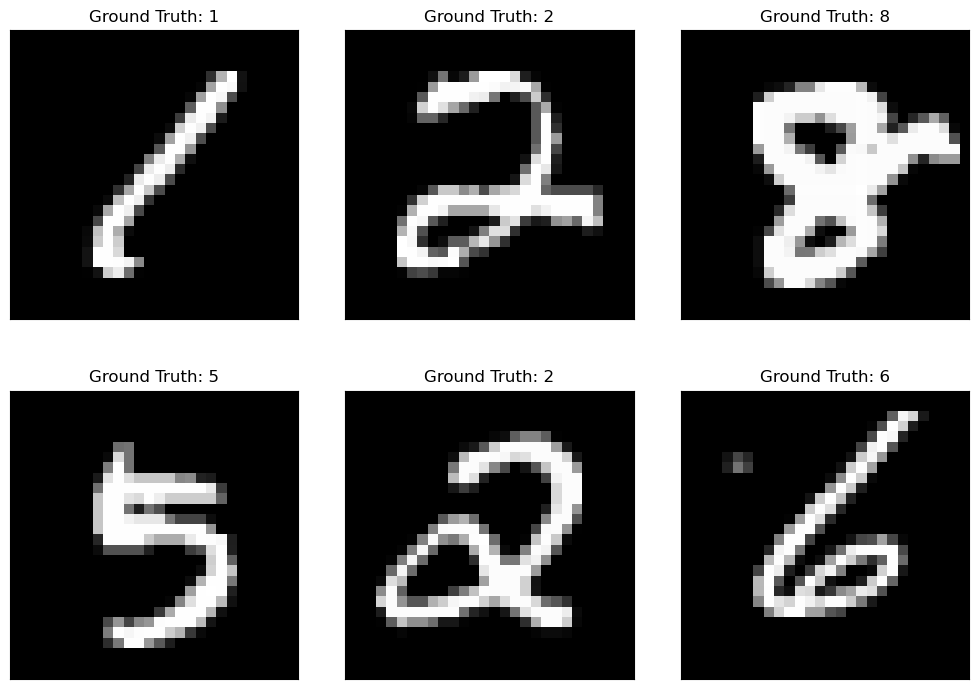

In [25]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
    
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Ground Truth: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()
plt.close()

# Define the Neural Network with 5 layers

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Input layer to first hidden layer
        self.fc1 = nn.Linear(28 * 28, 512)
        # First hidden layer to second hidden layer
        self.fc2 = nn.Linear(512, 256)
        # Second hidden layer to third hidden layer
        self.fc3 = nn.Linear(256, 128)
        # Third hidden layer to fourth hidden layer
        self.fc4 = nn.Linear(128, 64)
        # Fourth hidden layer to output layer
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten the input image
        x = x.view(-1, 28 * 28)
        
        # Layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Layer 2
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Layer 3
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Layer 4
        x = self.fc4(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Layer 5 (Output layer)
        x = self.fc5(x)
        
        return x

In [ ]:
model = NeuralNetwork().to(DEVICE)
criterion = nn.CrossEntropyLoss() # he loss function, applies the softmax function to the model outputs
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define training and test function

In [28]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Print statistics every 100 batches
        if batch_idx % 100 == 99:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {running_loss/100:.3f}, Accuracy: {100 * correct/total:.2f}%')
            running_loss = 0.0
    
    return 100 * correct / total

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            
            # Forward pass
            outputs = model(data)
            
            # Calculate loss
            test_loss += criterion(outputs, target).item()
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == target).sum().item()
    
    # Calculate average loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return accuracy


# Train and test the model

In [29]:
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 60)
    
    # Train the model
    train_accuracy = train(model, train_loader, optimizer, criterion, epoch)
    train_accuracies.append(train_accuracy)
    
    # Test the model
    test_accuracy = test(model, test_loader, criterion)
    test_accuracies.append(test_accuracy)


Epoch 1/5
------------------------------------------------------------
Epoch: 1, Batch: 100, Loss: 1.009, Accuracy: 66.19%
Epoch: 1, Batch: 200, Loss: 0.414, Accuracy: 76.92%
Epoch: 1, Batch: 300, Loss: 0.313, Accuracy: 81.58%
Epoch: 1, Batch: 400, Loss: 0.280, Accuracy: 84.18%
Epoch: 1, Batch: 500, Loss: 0.248, Accuracy: 85.94%
Epoch: 1, Batch: 600, Loss: 0.219, Accuracy: 87.27%
Epoch: 1, Batch: 700, Loss: 0.192, Accuracy: 88.31%
Epoch: 1, Batch: 800, Loss: 0.210, Accuracy: 89.06%
Epoch: 1, Batch: 900, Loss: 0.174, Accuracy: 89.70%
Test set: Average loss: 0.0020, Accuracy: 96.10%

Epoch 2/5
------------------------------------------------------------
Epoch: 2, Batch: 100, Loss: 0.155, Accuracy: 95.70%
Epoch: 2, Batch: 200, Loss: 0.158, Accuracy: 95.66%
Epoch: 2, Batch: 300, Loss: 0.150, Accuracy: 95.68%
Epoch: 2, Batch: 400, Loss: 0.144, Accuracy: 95.81%
Epoch: 2, Batch: 500, Loss: 0.142, Accuracy: 95.81%
Epoch: 2, Batch: 600, Loss: 0.132, Accuracy: 95.85%
Epoch: 2, Batch: 700, Loss:

# Results

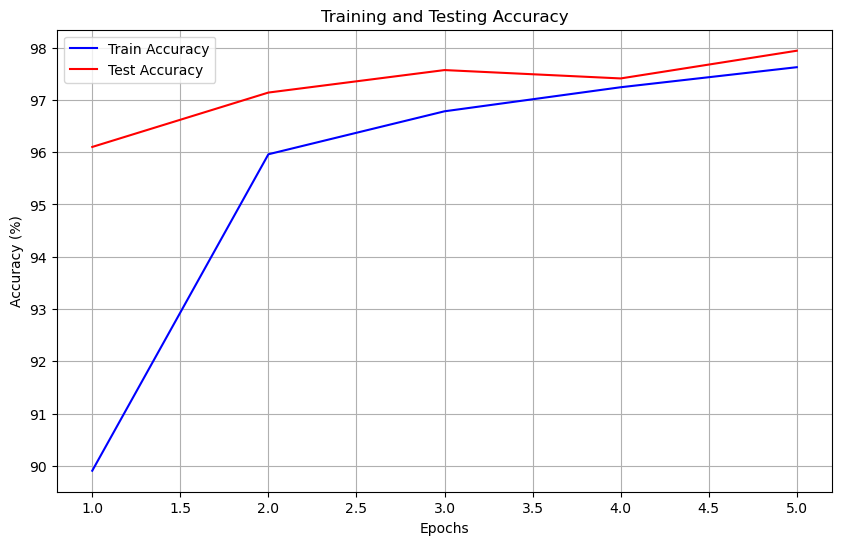

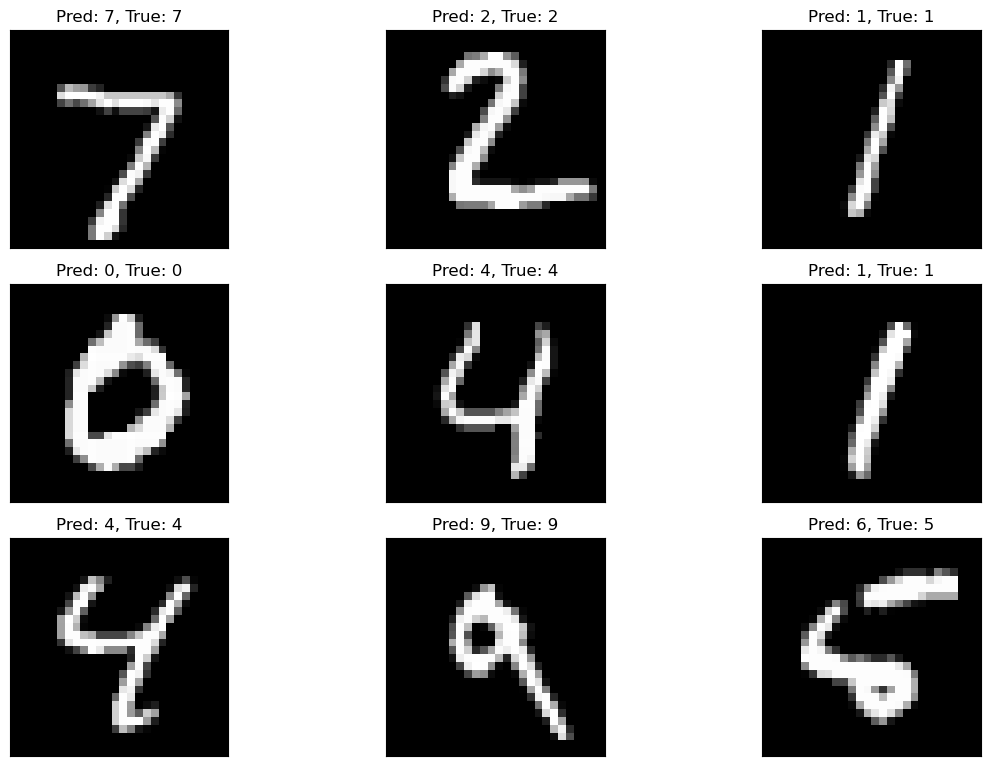


Model Summary:
NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total Parameters: 575050


In [30]:
# Plot the training and testing accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_accuracies, 'b-', label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), test_accuracies, 'r-', label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

# Visualize model predictions
model.eval()
with torch.no_grad():
    examples = enumerate(test_loader)
    batch_idx, (example_data, example_targets) = next(examples)
    example_data, example_targets = example_data.to(DEVICE), example_targets.to(DEVICE)
        
    outputs = model(example_data)
    _, predicted = torch.max(outputs.data, 1)
        
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0].cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f"Pred: {predicted[i]}, True: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()
plt.close()

# Save the trained model
torch.save(model.state_dict(), 'final_mnist_5layer_model.pth')

print("\nModel Summary:")
print(model)
print("\nTotal Parameters:", sum(p.numel() for p in model.parameters()))